In [ ]:
# Importing necessary libraries
from google.colab import drive
import os
import json
import multiprocessing as mp
from multiprocessing import Pool
from time import time
from datetime import timedelta
import nltk
nltk.download('all')
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress
import re
from tqdm import tqdm
import pickle as pk

stop_words = set(stopwords.words('english'))

The above outputs only shows the nltk downloads. So it is hidden to save space on the screen.

In [ ]:
# Mount the drive on colab
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Unzipping all the files
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/pdf_json.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/NLP_corpus/')

In [ ]:
# Considering only the JSON files
files = os.listdir('/content/NLP_corpus/pdf_json')
files = [x for x in files if x.endswith('.json')]
print(len(files))

56528


In [ ]:
# Path of all json files
Sroot = "/content/NLP_corpus/pdf_json"

In [ ]:
def json2text(filename):
  '''
  Preprocesses each file and returns (file_name, preprocessed_text)
  '''

  with open(os.path.join(Sroot, filename), 'r') as file:
      content = file.read()
      paper_content = json.loads(content)

      body_text = ""
      abstract = ""
      title = ""

      if 'title' in paper_content['metadata']:
          title = paper_content['metadata']['title']

      if 'abstract' in paper_content:
          for abs in paper_content['abstract']:
              abstract += abs['text']

      if 'body_text' in paper_content:
          for bt in paper_content['body_text']:
              body_text += bt['text']

      total_text = f"{title} {abstract} {body_text}"

      # Preprocessing

      # Removing html links
      pattern = r'http[s]?://\S+'
      total_text = re.sub(pattern, '', total_text)

      # Removing extra characters (not all, like - or :, etc.)
      pattern = r'[)(,.{}[\]<>?\/!@#$%^&*`~\'";=]'
      total_text = re.sub(pattern, '', total_text)

      # Removing numbers occuring as stand-alone words
      # Not all numbers, like in Covid-19
      words = word_tokenize(total_text)
      words = [word.lower() for word in words if word.isdigit() == False]

      # Finally, the stopwords
      words = [word for word in words if word not in stop_words]

      total_text = ' '.join(words)
      return (filename[:-5], total_text)

In [ ]:
def par_write(files):
  '''
  Uses multiprocessing to map the function json2text on all files, and saves the complete preprocessed corpus in a json file.
  '''
  start = time()

  total_files = len(files)

  progress = tqdm(total=total_files, desc="Processing Files")

  def update_progress(result):
      progress.update()

  with Pool() as p:
      results = []
      for file in files:
          res = p.apply_async(json2text, args=(file,), callback=update_progress)
          results.append(res)

      p.close()
      p.join()

  print(f"\nExtraction complete. Time taken = {timedelta(seconds = time() - start)}\n")

  result_dict = {res.get()[0]: res.get()[1] for res in results}

  print("Dictionary conversion complete")

  # Save the results to a JSON file
  with open('/content/drive/MyDrive/corpus.json', 'w') as f:
      json.dump(result_dict, f)

  print("Saving corpus.json complete")

In [ ]:
par_write(files)

Processing Files: 100%|█████████▉| 56524/56528 [22:31<00:00, 50.23it/s]


Extraction complete. Time taken = 0:22:31.383225

Dictionary conversion complete


Processing Files: 100%|██████████| 56528/56528 [22:50<00:00, 41.24it/s]

Saving corpus.json complete


Once the corpus is saved, we can use them anytime from the drive.

In [ ]:
with open('/content/drive/MyDrive/corpus.json', 'r') as f:
  content = f.read()
  json_content = json.loads(content)

In [ ]:
print(f"Type of file = {type(json_content)}")
print(f"Length of file = {len(json_content)}")

Type of file = <class 'dict'>
Length of file = 56528


# Zipf's Law

In [ ]:
def term_freq(x):
  '''
  Calculates the weighted term frequency for each token in the document x
  '''
  words = word_tokenize(x)
  freq_dist = FreqDist(words)
  weighted_freq_dist = FreqDist()
  for i in freq_dist:
    weighted_freq_dist[i] = freq_dist[i]/len(freq_dist)
  return weighted_freq_dist

In [ ]:
def freq_dist_mp(batch_size=100):
    """Processes documents in parallel and computes frequency distributions."""
    if not os.path.exists('/content/drive/MyDrive/freq_dist_list_batches'):
        os.makedirs('/content/drive/MyDrive/freq_dist_list_batches')

    start = time()
    total_docs = len(json_content)

    progress = tqdm(total=total_docs, desc="Processing Documents", leave=True, position=0)

    def update_progress(_):
        """Callback function to update the progress bar."""
        progress.update(1)

    batch_index = 0

    with Pool() as p:
        for i in range(0, total_docs, batch_size):
            batch_docs = list(json_content.values())[i:i + batch_size]

            results = [p.apply_async(term_freq, args=(doc,), callback=update_progress) for doc in batch_docs]

            batch_results = [res.get() for res in results]

            # Saving the batches to avoid holding all results in memory and memory crashes
            with open(f'/content/drive/MyDrive/freq_dist_list_batches/freq_dist_list_batch_{batch_index}.pickle', 'wb') as f:
                pk.dump(batch_results, f)

            batch_index += 1

    p.close()
    p.join()
    progress.close()

    print(f"\nMultiprocessing complete.\nTime taken = {timedelta(seconds=time() - start)}")

In [ ]:
freq_dist_mp(batch_size=1000)

Processing Documents: 100%|██████████| 56528/56528 [18:46<00:00, 50.17it/s]


Multiprocessing complete.
Time taken = 0:18:46.658149


In [ ]:
def addition(x):
  '''
  Simple addition of two frequency distributions
  '''
  return x[0] + x[1]

def freq_dist_add_mp(x):
  '''
  Multiptocessing to add all frequency distributions using addition function above
  '''
  start = time()
  while len(x) >= 2:
    new_x = []
    for i in range(0, (len(x)//2)*2, 2):
      new_x.append((x[i], x[i+1]))
    if len(x) % 2 != 0:
      new_x.append((x[-1], FreqDist()))
    p = Pool()
    x = p.map(addition, new_x, chunksize = 100)
    p.close()
    p.join()
  print(f"Time taken for addition = {timedelta(seconds = time() - start)}")
  return x[0]

This above function is actually very optimized, in the sense that it itteratively computes the overall frequency distribution, while using multiprocessing.

The following is a sketch of its working:

* Step 1: Let the list of frequency distributions be given as $$x = \left[x_1, x_2, x_3, x_4, \dots\right]$$
First, we make pairings of them.
$$x_{new} = \left[(x_1, x_2), (x_3, x_4), \dots\right]$$

* Step 2: On this, we apply addition function with multiprocessing to calculate the additions of pairs and save it to the original list (x here).

$$x = \text{addition}(x_{new}\text{ }\big|\text{ multiprocessing})$$
$$\Rightarrow x = \left[y_1, y_2, \dots\right]$$
Then, we just repeat this process, again making pairs $$x_{new} = \left[(y_1, y_2), \dots\right]$$

We keep on doing this iterative step, until the length of x is less than 2, in which case it has only one element, which is the addition of all frequency distributions.

Experimentally, this method proved to be a bit faster than just addition the frequency distributions in series.

In [ ]:
# Applying the multiprocessing function on the saved batches (57 in total)
freq_dist_list = []
print("57 iterations in total\n")
for i in range(57):
  with open(f'/content/drive/MyDrive/freq_dist_list_batches/freq_dist_list_batch_{i}.pickle', 'rb') as f:
    print(f"\nIteration {i+1}")
    freq_dist_list.append(freq_dist_add_mp(pk.load(f)))

57 iterations in total


Iteration 1
Time taken for addition = 0:00:19.734709

Iteration 2
Time taken for addition = 0:00:21.915457

Iteration 3
Time taken for addition = 0:00:18.758862

Iteration 4
Time taken for addition = 0:00:18.657235

Iteration 5
Time taken for addition = 0:00:19.069323

Iteration 6
Time taken for addition = 0:00:18.602656

Iteration 7
Time taken for addition = 0:00:18.031872

Iteration 8
Time taken for addition = 0:00:18.782496

Iteration 9
Time taken for addition = 0:00:20.120449

Iteration 10
Time taken for addition = 0:00:18.047660

Iteration 11
Time taken for addition = 0:00:18.838100

Iteration 12
Time taken for addition = 0:00:18.661741

Iteration 13
Time taken for addition = 0:00:19.324737

Iteration 14
Time taken for addition = 0:00:18.965387

Iteration 15
Time taken for addition = 0:00:17.233981

Iteration 16
Time taken for addition = 0:00:18.838356

Iteration 17
Time taken for addition = 0:00:20.286314

Iteration 18
Time taken for addition = 0:00:18.03

In [ ]:
# Finally, additing all the 57 frequency distributions to get the final one
all_freq_dist = FreqDist()
for one_freq_dist in freq_dist_list:
  all_freq_dist = all_freq_dist + one_freq_dist

In [ ]:
print(all_freq_dist)

<FreqDist with 2782837 samples and 135885 outcomes>


In [ ]:
print(pd.DataFrame(all_freq_dist.most_common(15), columns = ["Words", "Weighted Frequencies"]))

        Words  Weighted Frequencies
0    patients            847.712862
1    covid-19            716.954247
2           :            558.825140
3          et            543.845700
4          al            523.905136
5        also            469.854513
6         may            450.689610
7       study            441.273004
8        data            421.137722
9   infection            418.884103
10      virus            408.477833
11      cells            403.032156
12    disease            368.096534
13      using            358.752292
14       used            343.205489


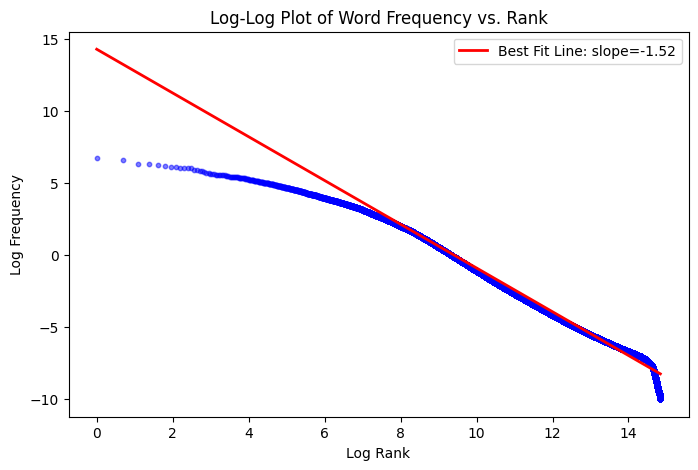

Slope of the line (should be close to -1 for Zipf's law): -1.52
R-squared value: -0.954


In [ ]:
# Plotting the data in log-log scale
frequencies = np.array(list(all_freq_dist.values()))
frequencies = np.sort(frequencies)[::-1]

ranks = np.arange(1, len(frequencies) + 1)

log_frequencies = np.log(frequencies)
log_ranks = np.log(ranks)

# Plot the frequency vs. rank on the log-log scale
plt.figure(figsize=(8, 5))
plt.scatter(log_ranks, log_frequencies, s=10, color='blue', alpha=0.5)
plt.title('Log-Log Plot of Word Frequency vs. Rank')
plt.xlabel('Log Rank')
plt.ylabel('Log Frequency')

# finding the line of best fit
slope, intercept, r_value, p_value, std_err = linregress(log_ranks, log_frequencies)

plt.plot(log_ranks, intercept + slope * log_ranks, color='red', linewidth=2, label=f'Best Fit Line: slope={round(slope, 2)}')
plt.legend()
plt.show()

print(f"Slope of the line (should be close to -1 for Zipf's law): {round(slope, 2)}")
print(f"R-squared value: {round(r_value, 4)}")

# Heap's Law

In [ ]:
with open('/content/drive/MyDrive/corpus.json', 'r') as f:
  content = f.read()
  json_content = json.loads(content)

In [ ]:
def chunking(files, chunk_size=10000, batch_size=1000, output_dir="chunks"):
  '''
  Divides the entire corpus into chunks of 10,000, while also saving 1000 such batches, to save RAM
  '''
  if not os.path.exists(output_dir):
      os.makedirs(output_dir)

  c = chunk_size
  one_list = []
  batch = []
  batch_count = 0

  progress = tqdm(total=len(files), desc=f"Processing documents", leave=True)

  for i, doc in enumerate(files):
      words = word_tokenize(doc)

      while len(words) > 0:
          if len(words) < c:
              one_list.extend(words)
              c -= len(words)
              words = []  # All words from this doc have been added
          else:
              one_list.extend(words[:c])
              batch.append(one_list)
              one_list = []
              words = words[c:]
              c = chunk_size  # Reset the chunk size for the next chunk

          # Save the batch when it reaches batch_size
          if len(batch) >= batch_size:
              with open(os.path.join(output_dir, f"chunk_batch_{batch_count}.pkl"), 'wb') as f:
                  pk.dump(batch, f)
              batch = []
              batch_count += 1

      progress.update(1)

  # Saving the last remaining batch to disk
  if len(batch) > 0:
      with open(os.path.join(output_dir, f"chunk_batch_{batch_count}.pkl"), 'wb') as f:
          pk.dump(batch, f)

  # Append any remaining words in the last chunk
  if len(one_list) != 0:
      with open(os.path.join(output_dir, f"chunk_batch_{batch_count + 1}.pkl"), 'wb') as f:
          pk.dump([one_list], f)

  progress.close()

In [ ]:
chunking(list(json_content.values()), chunk_size=10000, batch_size=1000, output_dir = '/content/drive/MyDrive/vocab_chunk_batches')

Processing documents: 100%|██████████| 56528/56528 [14:35<00:00, 64.55it/s]


In [ ]:
def vocabulary(x):
    """
    Calculates vocabulary size and unique set of words for a given chunk.
    """
    return (len(x), set(x))

def load_pickle_files(directory):
    """
    Loads all pickle files from a given directory.
    """
    pickle_files = sorted([os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.pkl')])
    return pickle_files

def process_pickle_file(file_path):
    """
    Processes each pickle file to calculate vocabulary for each chunk in it.
    """
    with open(file_path, 'rb') as f:
        chunk = pk.load(f)  # Load the chunk data
    vocab_results = [vocabulary(chunk_part) for chunk_part in chunk]
    return vocab_results

def vocab_mp(pickle_directory):
    """
    Calculates the vocabulary for each chunk using multiprocessing.
    """
    start = time()

    pickle_files = load_pickle_files(pickle_directory)

    total_files = len(pickle_files)

    progress = tqdm(total=total_files, desc="Processing pickle files")

    def update_progress(_):
        progress.update()

    all_results = []

    with Pool() as p:
        results = []
        for file_path in pickle_files:
            res = p.apply_async(process_pickle_file, args=(file_path,), callback=update_progress)
            results.append(res)

        for res in results:
            all_results.extend(res.get())

        p.close()
        p.join()
        progress.close()

    print(f"\nMultiprocessing complete.\nTime taken = {timedelta(seconds = time() - start)}")
    return all_results

In [ ]:
# The directory where the pickle files are stored
pickle_directory = '/content/drive/MyDrive/vocab_chunk_batches'

vocab_listing = vocab_mp(pickle_directory)

Processing pickle files: 100%|██████████| 15/15 [01:12<00:00,  4.82s/it]


Multiprocessing complete.
Time taken = 0:01:12.356543


In [ ]:
def cumulative_vocab_optimized(vocab_list):
    """
    Computes cumulative vocabulary size across chunks.
    """
    cumulative_result = []
    total_tokens = 0
    cumulative_vocab = set()

    for (num_tokens, vocab_set) in tqdm(vocab_list, desc="Calculating cumulative vocabulary"):
        total_tokens += num_tokens # Update the total number of tokens
        cumulative_vocab.update(vocab_set)  # Update the cumulative vocabulary set
        cumulative_result.append((total_tokens, len(cumulative_vocab)))  # Store the total tokens and vocab size

    return cumulative_result

In [ ]:
total_token_vocab_list = cumulative_vocab_optimized(vocab_listing)

Calculating cumulative vocabulary: 100%|██████████| 13656/13656 [00:11<00:00, 1167.03it/s]


In [ ]:
a, b = total_token_vocab_list[-1]
print(f"Total number of tokens = {a}")
print(f"Total size of vocabulary = {b}")

Total number of tokens = 136553032
Total size of vocabulary = 2782837


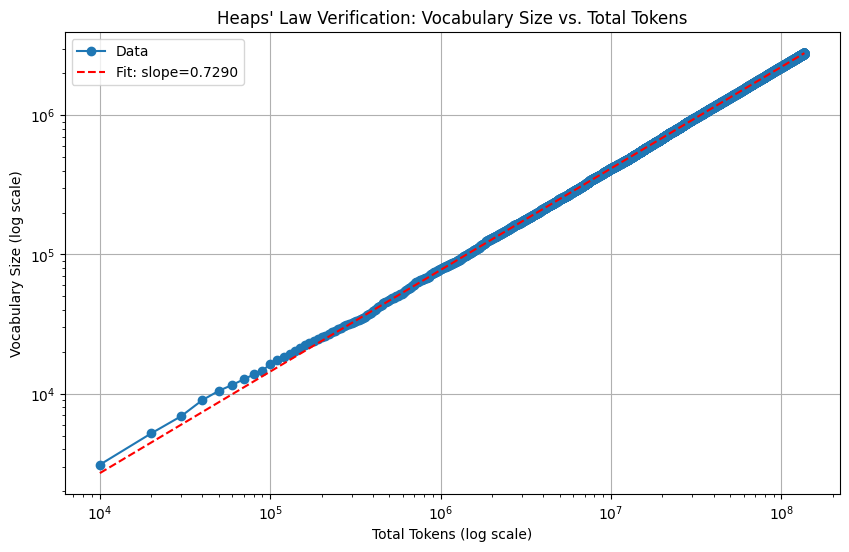

Estimated slope (beta) from Heaps' law: 0.7290


In [ ]:
# Plotting the vocabulary size and token size on log-log scale

tokens, vocab_sizes = zip(*total_token_vocab_list)

tokens = np.array(tokens)
vocab_sizes = np.array(vocab_sizes)

plt.figure(figsize=(10, 6))
plt.loglog(tokens, vocab_sizes, marker='o', linestyle='-', label='Data')

log_tokens = np.log10(tokens)
log_vocab_sizes = np.log10(vocab_sizes)

slope, intercept = np.polyfit(log_tokens, log_vocab_sizes, 1)

plt.plot(tokens, 10**(intercept + slope * log_tokens), linestyle='--', color='red', label=f'Fit: slope={slope:.4f}')

plt.xlabel('Total Tokens (log scale)')
plt.ylabel('Vocabulary Size (log scale)')
plt.title('Heaps\' Law Verification: Vocabulary Size vs. Total Tokens')
plt.legend()
plt.grid(True)
plt.show()

print(f"Estimated slope (beta) from Heaps' law: {slope:.4f}")